In [1]:
import pandas as pd 
import numpy as np
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
# pip install -U scikit-learn

In [3]:
data = pd.read_csv('spam.csv')
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Data Cleaning and Prepocessing

In [4]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS)
    return text

# Define the remove stop words function
def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_tokens)

# Apply the cleaning functions
data['Message'] = data['Message'].apply(clean_text).apply(remove_stop_words)

print(data.head())

  Category                                            Message
0      ham  jurong point crazy available bugis n great wor...
1      ham                            ok lar joking wif u oni
2     spam  free entry 2 wkly comp win fa cup final tkts 2...
3      ham                        u dun say early hor u c say
4      ham                      nah dont think goes usf lives


In [5]:
data['label'] = data['Category'].apply(lambda x: 0.0 if x == 'ham' else 1.0)
data.head()

,Category,Message,label
0,ham,jurong point crazy available bugis n great wor...,0.0
1,ham,ok lar joking wif u oni,0.0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1.0
3,ham,u dun say early hor u c say,0.0
4,ham,nah dont think goes usf lives,0.0


### TF-IDF

In [6]:
#Need to reduce the number of features from 3000 to 100, too many features to run for PCA+GMM
X = data['Message']
y = data['label']

#The model we will need to evaluate in train, test, validation set. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(X)
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

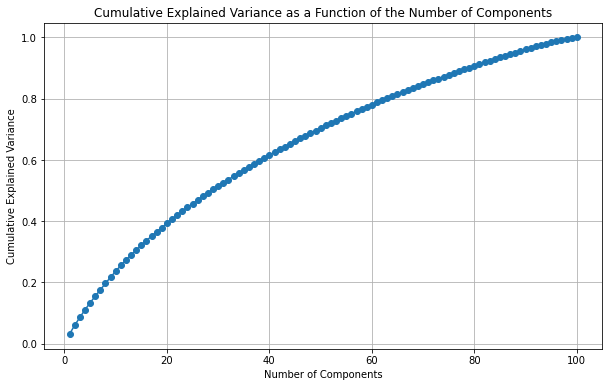

In [7]:
pca = PCA().fit(X_tfidf.toarray())

# Calculate cumulative explained variance ratio
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the elbow chart
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

In [8]:
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Display the first few rows of the DataFrame
tfidf_df

,amp,ask,babe,buy,care,cash,claim,come,contact,cos,...,want,wat,way,week,went,win,won,work,yeah,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.616585,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.575093,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.437018,0.0,0.477017,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.473208,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.543524,0.0,0.000000,0.000000,0.0,0.0,0.0


In [9]:
pca = PCA(n_components=2)  # Adjust n_components based on desired variance to keep
X_pca = pca.fit_transform(X_tfidf.toarray())

# Apply GMM
gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components based on expected clusters
gmm.fit(X_pca)
cluster_labels = gmm.predict(X_pca)

# Add cluster labels to your dataframe
data['cluster_label'] = cluster_labels
data.head()

,Category,Message,label,cluster_label
0,ham,jurong point crazy available bugis n great wor...,0.0,0
1,ham,ok lar joking wif u oni,0.0,0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1.0,0
3,ham,u dun say early hor u c say,0.0,0
4,ham,nah dont think goes usf lives,0.0,0


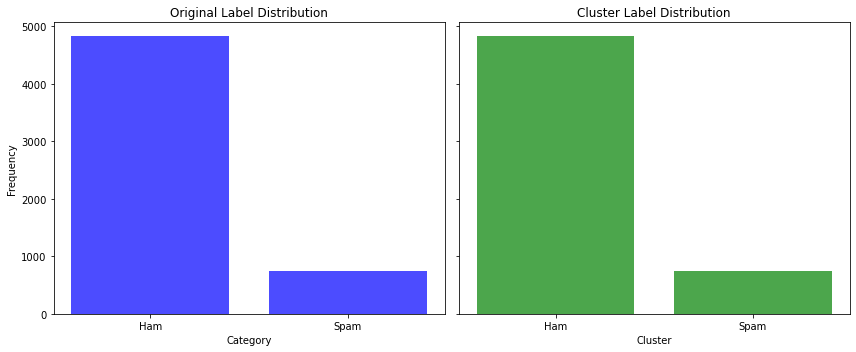

In [10]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Original Label Distribution
axes[0].hist(data['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='blue', alpha=0.7)
axes[0].set_title('Original Label Distribution')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Ham', 'Spam'])
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Category')

# Cluster Label Distribution
axes[1].hist(data['cluster_label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='green', alpha=0.7)
axes[1].set_title('Cluster Label Distribution')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Ham', 'Spam'])
axes[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

In [ ]:
#Analyzing Non-zero Features
# document_vector = tfidf_df.iloc[0]
# non_zero_features = document_vector[document_vector > 0]
# print(non_zero_features.sort_values(ascending=False))

### Accuracy

In [ ]:
#The model we will need to evaluate in train, test, validation set. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Need a model: Logistic regression model here

In [ ]:
# Model evaluation
# pred_train = model.predict(X_train_tfidf)
# acc_train = accuracy_score(y_train, pred_train)

# pred_test = model.predict(X_test_tfidf)
# acc_test_ = accuracy_score(y_test, pred_test)

# # Print accuracy
# print('Accuracy on training data: {}'.format(acc_train))
# print('Accuracy on test data: {}'.format(acc_test))

### Confusion Matrix

In [ ]:
# conf_matrix = confusion_matrix(y_test, pred_test)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest",
#             xticklabels=['Spam', 'Ham'], yticklabels=['Spam', 'Ham'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# classification_rep = classification_report(y_test, pred_test,target_names=['Spam', 'Ham'])
# print(classification_rep)